In [132]:
import pandas as pd
import numpy as np

from sklearn.model_selection import *

from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
from sklearn.impute import SimpleImputer

import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [133]:
train=pd.read_csv('Untitled Folder/train.csv')
test=pd.read_csv('Untitled Folder/test.csv')


dict_stay={'0-10':0,'11-20':1, '21-30':2, '31-40':3, '41-50':4, '51-60':5, '61-70':6, '71-80':7,
        '81-90':8, '91-100':9, 'More than 100 Days':10}

train['Stay'].replace(dict_stay,inplace=True)
train.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,4
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,3
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,4
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,4


In [134]:
agg1=train.groupby(['Hospital_type_code','Department','Ward_Facility_Code','Bed Grade','Type of Admission','Severity of Illness','Age','Stay']).size().unstack().reset_index()
agg1.columns=['Hospital_type_code', 'Department','Ward_Facility_Code' ,'Bed Grade','Type of Admission', 'Severity of Illness','Age',
              's0','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10']

s_cols=['s0','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10']
agg1['sum_']=agg1[s_cols].sum(axis=1)
for col in s_cols:
    agg1[col]=round(100*agg1[col]/agg1['sum_'],2)
agg1.drop(['sum_'],axis=1,inplace=True)
agg1.fillna(0,inplace=True)

for col in s_cols:
    agg1[col]=np.where(agg1[col]==0,0,1)
    
agg1.head()

,Hospital_type_code,Department,Ward_Facility_Code,Bed Grade,Type of Admission,Severity of Illness,Age,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10
0,a,TB & Chest disease,B,1.0,Emergency,Extreme,41-50,0,0,1,0,0,0,0,0,0,0,0
1,a,TB & Chest disease,B,1.0,Emergency,Minor,51-60,0,0,0,1,0,0,0,0,0,0,0
2,a,TB & Chest disease,B,1.0,Emergency,Minor,71-80,0,1,0,0,0,0,0,0,0,0,0
3,a,TB & Chest disease,B,1.0,Emergency,Moderate,21-30,0,0,1,0,0,0,0,0,0,0,0
4,a,TB & Chest disease,B,1.0,Emergency,Moderate,71-80,1,0,0,0,0,0,0,0,0,0,0


In [135]:
train=pd.merge(train,agg1,on=['Hospital_type_code', 'Department','Ward_Facility_Code' ,'Bed Grade',
                              'Type of Admission', 'Severity of Illness','Age'],how='left')
test=pd.merge(test,agg1,on=['Hospital_type_code', 'Department','Ward_Facility_Code' ,'Bed Grade',
                            'Type of Admission', 'Severity of Illness','Age'],how='left')

In [136]:
agg2=train.groupby(['Type of Admission','Severity of Illness','Age','Stay']).size().unstack().reset_index()
agg2.columns=['Type of Admission', 'Severity of Illness','Age',
              's0','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10']

s_cols=['s0','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10']
agg2['sum_']=agg2[s_cols].sum(axis=1)
for col in s_cols:
    agg2[col]=round(100*agg2[col]/agg2['sum_'],2)
agg2.drop(['sum_'],axis=1,inplace=True)
agg2.fillna(0,inplace=True)

for col in s_cols:
    agg2[col]=np.where(agg2[col]==0,0,1)
    
agg2.head()

,Type of Admission,Severity of Illness,Age,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10
0,Emergency,Extreme,0-10,1,1,1,1,1,1,1,1,1,1,1
1,Emergency,Extreme,11-20,1,1,1,1,1,1,1,1,1,1,1
2,Emergency,Extreme,21-30,1,1,1,1,1,1,1,1,1,1,1
3,Emergency,Extreme,31-40,1,1,1,1,1,1,1,1,1,1,1
4,Emergency,Extreme,41-50,1,1,1,1,1,1,1,1,1,1,1


In [137]:
agg3=train.groupby(['Ward_Type','Ward_Facility_Code','Age','Stay']).size().unstack().reset_index()
agg3.columns=['Ward_Type','Ward_Facility_Code','Age',
              's0','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10']

s_cols=['s0','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10']
agg3['sum_']=agg3[s_cols].sum(axis=1)
for col in s_cols:
    agg3[col]=round(100*agg3[col]/agg3['sum_'],2)
agg3.drop(['sum_'],axis=1,inplace=True)
agg3.fillna(0,inplace=True)

for col in s_cols:
    agg3[col]=np.where(agg3[col]==0,0,1)
    
agg3.head()

,Ward_Type,Ward_Facility_Code,Age,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10
0,P,A,0-10,1,1,1,1,1,0,0,0,0,0,0
1,P,A,11-20,1,1,1,1,1,1,0,0,0,0,0
2,P,A,21-30,1,1,1,1,1,0,1,1,1,0,0
3,P,A,31-40,1,1,1,1,1,1,1,0,0,0,1
4,P,A,41-50,1,1,1,1,1,1,1,1,0,1,0


In [138]:
aggregations={\
               'case_id':'count',
               'Hospital_code':'nunique',
               'Hospital_type_code':'nunique',
               'City_Code_Hospital':'nunique',
               'Hospital_region_code':'nunique',
               'Department':'nunique',
               'Type of Admission':'nunique',
               'Admission_Deposit':'mean',
             }

patient_train=train.groupby(['patientid']).agg(aggregations)
patient_test=test.groupby(['patientid']).agg(aggregations)
                                

cols=['total_visits','uniqueHos','uniqueHosType','uniqueHosCity','uniqueHosRegion','uniqueDepartment','uniqueAdm','avgDeposit']
patient_train.columns=cols
patient_test.columns=cols

train=pd.merge(train,patient_train,on='patientid',how='left')
test=pd.merge(test,patient_test,on='patientid',how='left')

In [139]:
train_X=train.drop(['Stay'],axis=1)

train_X['type']='train'
test['type']='test'
data=pd.concat([train_X,test])

#fill na using group by
data['Bed Grade']=data.groupby(['Hospital_code'])['Bed Grade'].\
transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

data['City_Code_Patient']=data.groupby(['Hospital_region_code'])['City_Code_Patient'].\
transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

cat_col=['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code','Department', 'Ward_Type', 'Ward_Facility_Code',
       'City_Code_Patient', 'Type of Admission',
       'Severity of Illness','Age']

float_col=['Available Extra Rooms in Hospital','Visitors with Patient','Admission_Deposit',
          'total_visits','uniqueHos','uniqueHosType','uniqueHosCity','uniqueHosRegion','uniqueDepartment','uniqueAdm','avgDeposit','Bed Grade']

for col in cat_col:
    data[col]=le.fit_transform(data[col])

for col in float_col:
    data[col]=data[col].astype(float)

In [140]:
aggregations={\
               'case_id':'count',
               'patientid':'nunique' ,               
               'Department':'nunique',
               'Type of Admission':'nunique',
               'Admission_Deposit':'mean',
            }

hospital_data=data.groupby(['Hospital_code']).agg(aggregations)

cols=['h_cases','h_patient','h_dep','h_typeadm','h_avgdeposit']
hospital_data.columns=cols

data=pd.merge(data,hospital_data,on='Hospital_code',how='left')

data['hosp_deposit']=data.groupby(['Hospital_code','Department','Type of Admission','Severity of Illness'])['Admission_Deposit'].transform('mean')
data['per_dep_above_hosp']=100*(data['Admission_Deposit']-data['hosp_deposit'])/data['hosp_deposit']
data['per_dep_above_patient']=100*(data['Admission_Deposit']-data['avgDeposit'])/data['avgDeposit']
data.drop(['hosp_deposit'],axis=1,inplace=True)

data['hosp_ward_deposit']=data.groupby(['Hospital_code','Ward_Type','Ward_Facility_Code'])['Admission_Deposit'].transform('mean')
data['per_dep_above_ward']=100*(data['Admission_Deposit']-data['hosp_ward_deposit'])/data['hosp_ward_deposit']
data.drop(['hosp_ward_deposit'],axis=1,inplace=True)

data['dep_by_visitors']=data['Admission_Deposit']/(1+data['Visitors with Patient'])
data['visit_by_hosp']=data['total_visits']/data['uniqueHos']
data['visit_by_region']=data['total_visits']/data['uniqueHosRegion']

In [141]:
train_X=data[data['type']=='train']
test_=data[data['type']=='test']
train_X.drop(['type'],axis=1,inplace=True)
test_.drop(['type'],axis=1,inplace=True)

X = train_X.drop(['case_id','patientid','City_Code_Hospital'],axis=1)
y = train['Stay']
test_=test_[X.columns]

In [142]:
X.head()

,Hospital_code,Hospital_type_code,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,total_visits,uniqueHos,uniqueHosType,uniqueHosCity,uniqueHosRegion,uniqueDepartment,uniqueAdm,avgDeposit,h_cases,h_patient,h_dep,h_typeadm,h_avgdeposit,per_dep_above_hosp,per_dep_above_patient,dep_by_visitors,visit_by_hosp,visit_by_region,per_dep_above_ward
0,7,2,2,3.0,3,2,5,2.0,6,0,0,2.0,5,4911.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,10.0,7.0,7.0,3.0,3.0,3.0,5951.0,5284,5114,5,3,4920.411809,6.304454,-17.476054,1637.000000,1.4,4.666667,-1.725020
1,1,2,2,2.0,3,3,5,2.0,6,1,0,2.0,5,5954.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,14.0,10.0,7.0,7.0,3.0,3.0,3.0,5951.0,7277,6134,5,3,4998.556685,20.087493,0.050412,1984.666667,1.4,4.666667,18.260201
2,9,4,0,2.0,1,3,4,2.0,6,1,0,2.0,5,4745.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,14.0,10.0,7.0,7.0,3.0,3.0,3.0,5951.0,13538,12886,5,3,4556.475772,-4.804895,-20.265502,1581.666667,1.4,4.666667,3.989670
3,25,1,1,2.0,3,2,3,2.0,6,1,0,2.0,5,7272.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,14.0,10.0,7.0,7.0,3.0,3.0,3.0,5951.0,47523,37279,5,3,4895.473644,48.723490,22.197950,2424.000000,1.4,4.666667,46.294960
4,25,1,1,2.0,3,3,3,2.0,6,1,0,2.0,5,5558.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,14.0,10.0,7.0,7.0,3.0,3.0,3.0,5951.0,47523,37279,5,3,4895.473644,13.669576,-6.603932,1852.666667,1.4,4.666667,13.112425


In [159]:
X_temp=X.drop(['h_dep','s0','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10'],axis=1)
test_2=test_[X_temp.columns]


cat_col=['Hospital_code','Hospital_type_code','Ward_Facility_Code',
       'Hospital_region_code','Department', 'Ward_Type',
       'City_Code_Patient', 'Type of Admission',
       'Severity of Illness','Age']

cat_cols=[X_temp.columns.get_loc(c) for c in cat_col]


clf_lgb = lgb.LGBMClassifier(boosting_type='gbdt', 
                   objective='multiclass',
                   num_class=11,
                   num_iteration=500, 
                      
                   max_depth=50,
                   min_data_in_leaf=50,
                   colsample_bytree=0.8,
                   subsample=0.9,
                   reg_alpha=1.6, 
                   reg_lambda=1.1,
                     
                   learning_rate=0.075,
                   categorical_feature = cat_cols,
                   random_state=101
                     )

In [ ]:
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=101)
cv_score = []
pred_test_lgb =np.zeros((len(test_),11))
pred_train =np.zeros((len(X_temp),11))

feat_imp=np.zeros((len(X_temp.columns),1))

for train_index,test_index in skf.split(X_temp,y):
    x_train,x_val = X_temp.iloc[train_index],X_temp.iloc[test_index]
    y_train,y_val = y.iloc[train_index],y.iloc[test_index]
    clf = clf_lgb
    clf.fit(x_train,y_train)
    score = round(accuracy_score(y_val,clf.predict(x_val)),2)
    cv_score.append(score)
    print(score,end=",")
    
    #predictions
    pred_train += clf.predict_proba(X_temp).reshape(-1,11)
    pred_test_lgb += clf.predict_proba(test_2).reshape(-1,11)
    feat_imp += clf.feature_importances_.reshape(-1,1)
    
pred_train=pred_train/10
pred_test_lgb = pred_test_lgb/10
feat_imp = feat_imp/10

feature_imp = pd.DataFrame(sorted(zip(X_temp.columns,feat_imp)), columns=['Feature','Value'])
feature_imp=feature_imp.sort_values(by='Value',ascending=False)

arg_pred_test=[]
for item in pred_test_lgb:
    arg_pred_test.append(np.argmax(item))
    
arg_pred_train=[]
for item in pred_train:
    arg_pred_train.append(np.argmax(item))
    
print(np.mean(cv_score))

0.44,0.43,

In [156]:
sub=pd.DataFrame()
sub['Stay']=arg_pred_test
sub.index=test.case_id
sub=sub[['Stay']]
inv_map_dict_stay = {v: k for k, v in dict_stay.items()}
sub['Stay'].replace(inv_map_dict_stay,inplace=True)
sub.to_csv('try1.csv')
sub.head()

,Stay
case_id,
318439,0-10
318440,51-60
318441,21-30
318442,21-30
318443,51-60


In [97]:
feature_imp

,Feature,Value
6,Hospital_code,[39142.8]
14,avgDeposit,[28000.1]
4,City_Code_Patient,[26264.0]
15,dep_by_visitors,[25520.3]
21,per_dep_above_patient,[23619.9]
20,per_dep_above_hosp,[21589.9]
0,Admission_Deposit,[18534.0]
40,visit_by_hosp,[11896.7]
41,visit_by_region,[11806.3]
1,Age,[11416.7]


In [99]:
df=pd.DataFrame()
df['Stay_original']=train.Stay
df['Stay_pred']=arg_pred_train
inv_map_dict_stay = {v: k for k, v in dict_stay.items()}
df['Stay_original'].replace(inv_map_dict_stay,inplace=True)
df['Stay_pred'].replace(inv_map_dict_stay,inplace=True)

pd.crosstab(df.Stay_original,df.Stay_pred)

Stay_pred,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-100,More than 100 Days
Stay_original,,,,,,,,,,,
0-10,9707,7879,5853,99,8,51,1,5,0,0,1
11-20,1495,48117,23811,2730,26,1904,1,43,6,1,5
21-30,1212,17170,66982,970,31,1019,0,29,50,0,28
31-40,782,7597,21084,19252,37,6190,0,130,42,3,42
41-50,255,1352,6481,535,2457,633,0,12,12,1,5
51-60,305,2050,4486,3910,22,23870,0,97,149,1,128
61-70,9,51,660,40,0,124,1851,1,5,0,3
71-80,63,311,761,972,2,3397,1,4607,32,0,108
81-90,8,19,42,119,0,450,0,5,4177,0,18


In [119]:
opt=X.copy()
inv_map_dict_stay = {v: k for k, v in dict_stay.items()}
opt['Stay']=y
opt['Stay'].replace(inv_map_dict_stay,inplace=True)
opt.head()

,Hospital_code,Hospital_type_code,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,total_visits,uniqueHos,uniqueHosType,uniqueHosCity,uniqueHosRegion,uniqueDepartment,uniqueAdm,avgDeposit,h_cases,h_patient,h_dep,h_typeadm,h_avgdeposit,per_dep_above_hosp,per_dep_above_patient,dep_by_visitors,visit_by_hosp,visit_by_region,Stay
0,7,2,2,3.0,3,2,5,2.0,6,0,0,2.0,5,4911.0,20.0,0.00,60.00,20.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,14.0,10.0,7.0,7.0,3.0,3.0,3.0,5951.0,5284,5114,5,3,4920.411809,6.304454,-17.476054,1637.000000,1.4,4.666667,0-10
1,1,2,2,2.0,3,3,5,2.0,6,1,0,2.0,5,5954.0,0.0,0.00,13.33,46.67,6.67,13.33,0.00,20.0,0.0,0.00,0.00,14.0,10.0,7.0,7.0,3.0,3.0,3.0,5951.0,7277,6134,5,3,4998.556685,20.087493,0.050412,1984.666667,1.4,4.666667,41-50
2,9,4,0,2.0,1,3,4,2.0,6,1,0,2.0,5,4745.0,8.0,16.00,32.00,12.00,4.00,16.00,0.00,0.0,12.0,0.00,0.00,14.0,10.0,7.0,7.0,3.0,3.0,3.0,5951.0,13538,12886,5,3,4556.475772,-4.804895,-20.265502,1581.666667,1.4,4.666667,31-40
3,25,1,1,2.0,3,2,3,2.0,6,1,0,2.0,5,7272.0,0.0,21.05,23.68,21.05,13.16,13.16,2.63,0.0,0.0,2.63,2.63,14.0,10.0,7.0,7.0,3.0,3.0,3.0,5951.0,47523,37279,5,3,4895.473644,48.723490,22.197950,2424.000000,1.4,4.666667,41-50
4,25,1,1,2.0,3,3,3,2.0,6,1,0,2.0,5,5558.0,0.0,21.05,23.68,21.05,13.16,13.16,2.63,0.0,0.0,2.63,2.63,14.0,10.0,7.0,7.0,3.0,3.0,3.0,5951.0,47523,37279,5,3,4895.473644,13.669576,-6.603932,1852.666667,1.4,4.666667,41-50


In [33]:
opt['hosp_deposit']=opt.groupby(['Hospital_code','Department','Type of Admission','Severity of Illness'])['Admission_Deposit'].transform('mean')
opt['per_dep_above_hosp']=100*(opt['Admission_Deposit']-opt['hosp_deposit'])/opt['hosp_deposit']
opt['per_dep_above_patient']=100*(opt['Admission_Deposit']-opt['avgDeposit'])/opt['avgDeposit']
opt['dep_by_visitors']=opt['Admission_Deposit']/(1+opt['Visitors with Patient'])
opt['visit_by_hosp']=opt['total_visits']/opt['uniqueHos']
opt['visit_by_region']=opt['total_visits']/opt['uniqueHosRegion']

In [128]:
opt['hosp_ward_deposit']=opt.groupby(['Hospital_code','Ward_Type','Ward_Facility_Code'])['Admission_Deposit'].transform('mean')
opt['per_dep_above_ward']=100*(opt['Admission_Deposit']-opt['hosp_ward_deposit'])/opt['hosp_ward_deposit']

In [129]:
opt.groupby(['Stay'])['per_dep_above_ward'].describe()

,count,mean,std,min,25%,50%,75%,max
Stay,,,,,,,,
0-10,23604.0,-5.590014,21.208739,-64.501289,-19.388959,-7.584443,6.022462,106.380619
11-20,78139.0,1.423935,20.030824,-64.120606,-11.195073,-1.189323,10.996033,120.791458
21-30,87491.0,2.950061,20.319211,-63.816059,-9.799652,0.056005,12.501480,135.609456
31-40,55159.0,-0.246995,21.806738,-63.841529,-14.307603,-3.537116,9.895411,137.014900
41-50,11743.0,-0.147594,22.923332,-62.279659,-14.053490,-1.791620,11.615070,133.069233
51-60,35018.0,-3.022415,23.324330,-62.612378,-18.082627,-7.552042,6.809014,132.649576
61-70,2744.0,-1.144488,26.250297,-61.991712,-17.898648,-2.880161,12.734215,113.650463
71-80,10254.0,-4.005659,24.138153,-62.176033,-19.049290,-8.327913,6.386306,114.059800
81-90,4838.0,-6.163115,26.611496,-62.848242,-23.806583,-12.349211,4.555837,123.180175


Stay
0-10                  AxesSubplot(0.125,0.125;0.775x0.755)
11-20                 AxesSubplot(0.125,0.125;0.775x0.755)
21-30                 AxesSubplot(0.125,0.125;0.775x0.755)
31-40                 AxesSubplot(0.125,0.125;0.775x0.755)
41-50                 AxesSubplot(0.125,0.125;0.775x0.755)
51-60                 AxesSubplot(0.125,0.125;0.775x0.755)
61-70                 AxesSubplot(0.125,0.125;0.775x0.755)
71-80                 AxesSubplot(0.125,0.125;0.775x0.755)
81-90                 AxesSubplot(0.125,0.125;0.775x0.755)
91-100                AxesSubplot(0.125,0.125;0.775x0.755)
More than 100 Days    AxesSubplot(0.125,0.125;0.775x0.755)
Name: per_dep_above_ward, dtype: object

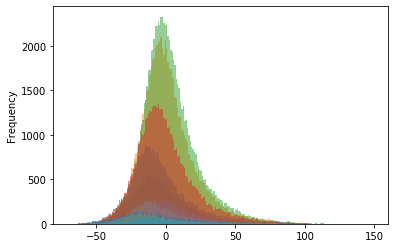

In [131]:
opt.groupby(['Stay'])['per_dep_above_ward'].plot(kind='hist',bins=np.arange(-70,150,1),alpha=0.5)

In [ ]:
train2=train_X.drop(['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'patientid', 'City_Code_Patient', 'Type of Admission',
       'Severity of Illness', 'Visitors with Patient', 'Age'],axis=1)
test2=test_[train2.columns]


impute_median=SimpleImputer(missing_values=np.nan,strategy='mean')
s_col=['s0', 's1', 's2', 's3', 's4', 's5', 's6', 's7','s8', 's9', 's10']
for c in s_col:
    train2[c]=impute_median.fit_transform(train2[[c]]).ravel()
    test2[c]=impute_median.fit_transform(test2[[c]]).ravel()
train2.head()

In [ ]:
#Logistic Doesnt improve
# skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=101)
# cv_score = []
# pred_test_log =np.zeros((len(test_),11))

# for train_index,test_index in skf.split(train2,y):
#     x_train,x_val = train2.iloc[train_index],train2.iloc[test_index]
#     y_train,y_val = y.iloc[train_index],y.iloc[test_index]
#     clf = LogisticRegression(C=1)
#     clf.fit(x_train,y_train)
#     score = round(accuracy_score(y_val,clf.predict(x_val)),2)
#     cv_score.append(score)
#     print(score,end=",")
    
#     #predictions
#     pred_test_log += clf.predict_proba(test2).reshape(-1,11)
    
# pred_test_log=pred_test_log/10

In [ ]:
def keras_model(input_dim=len(train2.columns)):
    model = Sequential()
    model.add(Dense(64, input_dim = input_dim , activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(256, activation = 'relu'))
#     model.add(Dense(64, activation = 'relu'))
    model.add(Dense(11, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )
    return model

skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=101)
cv_score = []
pred_test_log =np.zeros((len(test_),11))
dummy_y = np_utils.to_categorical(y)

for train_index,test_index in skf.split(train2,y):
    x_train,x_val = train2.iloc[train_index],train2.iloc[test_index]
    y_train,y_val = y.iloc[train_index],y.iloc[test_index]
    
    y_train = np_utils.to_categorical(y_train)
    
    model=keras_model().fit(x_train, y_train, epochs = 500, batch_size = 1000)
    score = round(accuracy_score(y_val,model.model.predict_classes(x_val)),2)
    cv_score.append(score)
    print(score,end=",")
    
    #predictions
    pred_test_keras += model.model.predict_proba(test2).reshape(-1,11)
    
pred_test_keras=pred_test_keras/10

In [ ]:
p=model.model.predict_classes(x_val)

In [ ]:
y_val

In [ ]:
round(accuracy_score(y_val,model.model.predict_classes(x_val)),2)

In [ ]:
pred_test_final=(pred_test_lgb+pred_test_keras)/2
arg_pred_final=[]
for item in pred_test_final:
    arg_pred_final.append(np.argmax(item))
    
sub=pd.DataFrame()
sub['Stay']=arg_pred_final
sub.index=test.case_id
sub=sub[['Stay']]
inv_map_dict_stay = {v: k for k, v in dict_stay.items()}
sub['Stay'].replace(inv_map_dict_stay,inplace=True)
sub.to_csv('try1.csv')
sub.head()

In [ ]:
# #grid search for best param
# kf = KFold(n_splits=5, shuffle=True, random_state=42).split(X,y)

# param_grid = {
#     'objective':'multiclass',
#     'num_class':[11],
#     'num_iteration':[1000],
#     'max_depth':[5,7],
#     'num_leaves': [30, 100],
#     'min_data_in_leaf': [5,10],
#     'learning_rate':[0.1],
#     }

# gsearch=GridSearchCV(estimator=clf_lgb,param_grid=param_grid,n_jobs=-1,verbose=0,return_train_score=True,cv=kf)

# lgb_model = gsearch.fit(X,y)
# print(lgb_model.best_params_, lgb_model.best_score_)

In [ ]:
# cat=CatBoostClassifier(iterations=1000,  
#                          learning_rate=0.1,
#                          loss_function='MultiClass',
#                          cat_features = cat_cols,
#                         verbose=False
#                         )

# x_train,x_test,y_train,y_test=train_test_split(X,y)
# clf=cat.fit(x_train,y_train)
# print(accuracy_score(y_test,clf.predict(x_test)))